In [1]:
!pip install git+https://github.com/lisphilar/covid19-sir#egg=covsirphy

In [2]:
import numpy as np
import pandas as pd
import math
from array import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, timedelta
from scipy.integrate import solve_ivp
from covsirphy import SIRD, line_plot
from matplotlib.colors import ListedColormap

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


# Analysis of R0 in PRC before 1st March

In [3]:
# Source from Ding Xiang Yuan
path = 'DXYOverall.csv'
df = pd.read_csv(path)
df['updateTime']=pd.to_datetime(df['updateTime'])
df=df[df['updateTime']<'2020-03-01']

In [4]:
# Tg: latent period
Tg = 7.5
# days: outbreak in PRC since December 2019 
df['days'] = df['updateTime'] - pd.to_datetime('2019/12/1', format="%Y/%m/%d")
df['days'] = df['days'].astype('timedelta64[D]')

def R0Func(confirm, suspect,t):
    # p: ratio of susceptible turning into confirmed case
    p = 41/59
    # yt: estimated infectious
    Yt = suspect * p + confirm
    # lamda: growth rate of estimated infectious
    lamda = math.log(Yt)/t
    R0 = 1 + lamda * Tg + p * (1 - p) * pow(lamda * Tg, 2)
    return R0

df['R0'] = df.apply(lambda x: R0Func(x['confirmedCount'], x['suspectedCount'], x['days']), axis = 1)

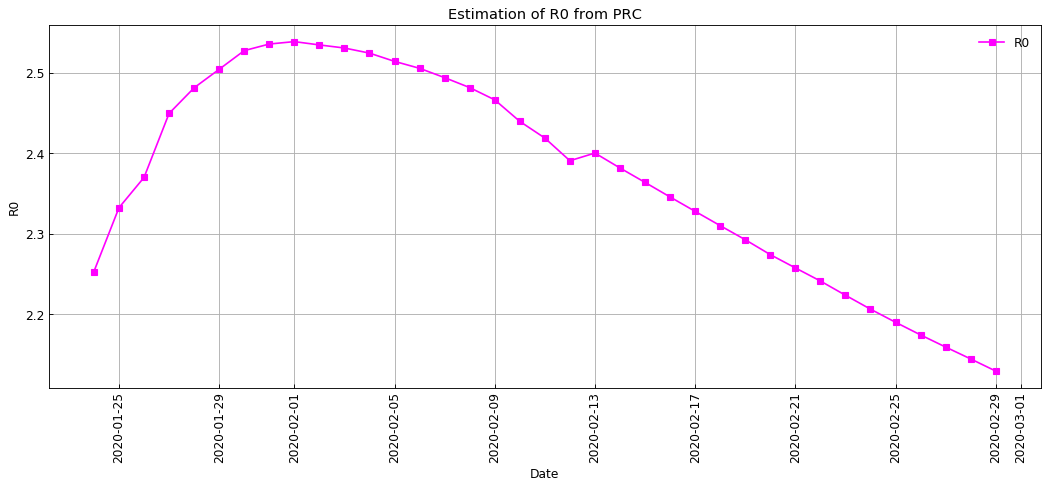

In [5]:
# graph
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
register_matplotlib_converters()
plt.plot(df['updateTime'], df['R0'], color = 'magenta',label = 'R0', marker = 's')
plt.legend()
plt.title('Estimation of R0 from PRC')
plt.grid()
plt.xlabel('Date')
plt.ylabel('R0')
plt.xticks(rotation = 90)
plt.show()

In [6]:
print('The maximum of R0 in RPC is '+str(round(df['R0'].max(),1)))

The maximum of R0 in RPC is 2.5


# SIR model

In [7]:
def simulation(model, initials, step_n, **params):
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=False
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

In [8]:
eg_r0, eg_kappa, eg_rho = (2.5, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.00000004, 0, 0)

In [9]:
eg_df = simulation(SIRD, eg_initials, step_n=250, kappa=eg_kappa, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

,t,x,y,z,w
246,246,0.107570,0.001876,0.833957,0.055597
247,247,0.107531,0.001769,0.834094,0.055606
248,248,0.107494,0.001669,0.834223,0.055615
249,249,0.107459,0.001574,0.834344,0.055623
250,250,0.107426,0.001484,0.834459,0.055631


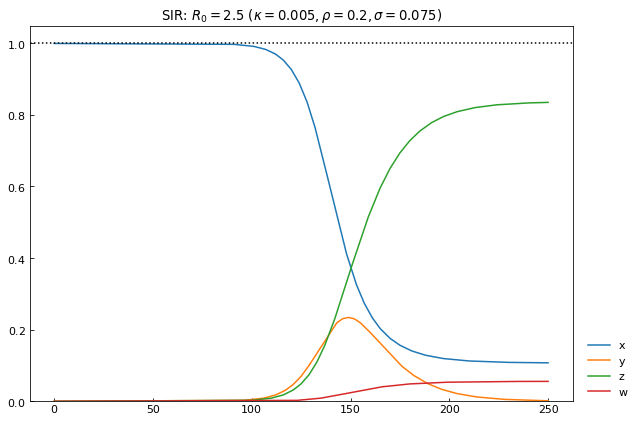

In [16]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0={0}\ (\kappa={1}, \rho={2}, \sigma={3})$".format(eg_r0, eg_kappa, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

In [11]:
eg_tau = 1440
eg_start_date = datetime.strptime('2020-01-24', "%Y-%m-%d")
eg_total_population = 66990000

In [12]:
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Susceptible": 0,
        "Confirmed": 0,
        "Infected": (eg_df["y"] * eg_total_population).astype(np.int64)
    }
)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population).astype(np.int64)
eg_ori_df["Deaths"] = (eg_df["w"] * eg_total_population).astype(np.int64)
eg_ori_df["Confirmed"] = eg_ori_df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
eg_ori_df["Susceptible"] = eg_total_population - eg_ori_df["Confirmed"]
eg_ori_df.tail()

,Date,Susceptible,Confirmed,Infected,Recovered,Deaths
246,2020-09-26,7273094,59716906,125648,55866805,3724453
247,2020-09-27,7270469,59719531,118511,55875957,3725063
248,2020-09-28,7267994,59722006,111778,55884589,3725639
249,2020-09-29,7265660,59724340,105427,55892731,3726182
250,2020-09-30,7263460,59726540,99436,55900410,3726694


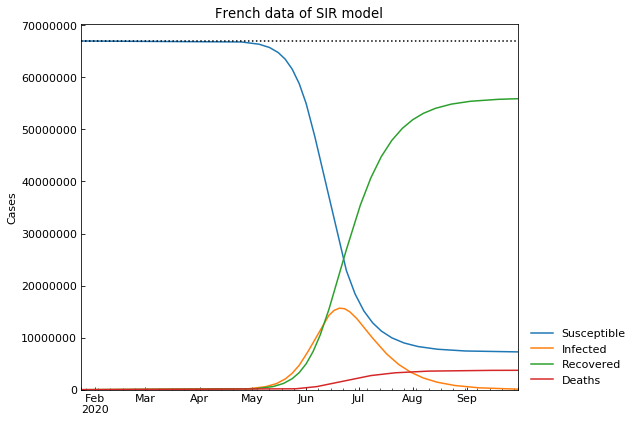

In [15]:
line_plot(
    eg_ori_df.set_index("Date")[["Susceptible", "Infected", "Recovered", "Deaths"]],
    "French data of SIR model",
    h=eg_total_population,
    y_integer=True
)

In [14]:
print("The population of France is "+str(f'{eg_total_population:,}'+"."))
print("The estimated confirmed case of France on "+eg_ori_df.loc[eg_ori_df["Confirmed"].idxmax(), "Date"].
      strftime("%Y/%m/%d")+" is "+str(f'{eg_ori_df["Confirmed"].max():,}')+", "
      +str(round(eg_ori_df["Confirmed"].max()/eg_total_population*100,1))
      +'% of total population.')
print("The estimated deaths of France on "+eg_ori_df.loc[eg_ori_df["Deaths"].idxmax(), "Date"].strftime("%Y/%m/%d")
      +" is "+str(f'{eg_ori_df["Deaths"].max():,}')+", "
      +str(round(eg_ori_df["Deaths"].max()/eg_total_population*100,1))
      +'% of total population.')

The population of France is 66,990,000.
The estimated confirmed case of France on 2020/09/30 is 59,726,540, 89.2% of total population.
The estimated deaths of France on 2020/09/30 is 3,726,694, 5.6% of total population.
